In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_venn import venn2
from src.tests.team_2.model_trainer_2 import load_data
from src.tests.team_2.model_trainer_2 import retrain
from src.utils.feature_analyzer import *
from src.utils.plot_utils import *
from src.utils.test_utils import *
from src.tests.team_2.model_trainer_2 import data_manipulator


In [420]:
###PIPELINE###
# 1 load training data
# 2 evaluate feature importance with permutation feature
# 3 select top feature to create a test for bias
# 5 test if there is actually bias
# 6 choose that feature or not.
# 7 remove feature from training data
# 8 repeat (2-7) until we have 5 features we believe have the most bias



In [421]:
biased_features = []

In [422]:
###TRAIN: no features removed
# X, y = load_data('../../data/synth_data_train_labeled.csv')
# retrain(X, y)

In [423]:
###LOAD DATA
RANDOM_STATE = 42

# Load in data (go back two parent directories)
df = pd.read_csv('data/investigation_train_large_checked.csv')
# Load in data descriptions
data_desc = pd.read_csv('data/data_description.csv', encoding='ISO-8859-1')

# Replace dutch for english names
name_mapping = dict(zip(data_desc['Feature (nl)'], data_desc['Feature (en)']))
# Rename the columns in the `data` DataFrame
df.rename(columns=name_mapping, inplace=True)

# Show data head
df.head()


,address_number_personal_records_database_addresses,address_number_different_districts,address_number_mail_address,address_number_residential_address_manual,address_days_at_address,address_latest_part_rotterdam,address_latest_neighborhood_groot_ijsselmonde,address_latest_neighborhood_new_westen,address_latest_neighborhood_other,address_latest_neighborhood_olde_north,...,type_hist_ind,type_hist_care_sector,type_ind,type_indication_secret_data,type_other,type_transport_logistics_horticulture,type_care_cleaning_wellbeing,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


In [424]:
def analyze_features(data, cache, filename):
    fa = FeatureAnalyzer()
    if cache:
        fa.evaluate_importance(dataframe=data, target='checked', add_drop=['Ja', 'Nee'], filepath=filename)
    fa = FeatureAnalyzer()
    fa.load_importance(filepath=filename)

    # Select original training data
    X = df.drop(['checked', 'Ja', 'Nee'], axis=1)
    y = df['checked']
    # Convert permutation importance to dictionary
    perm_import = fa.feature_importance_as_dict(column_names=X.columns, normalize=True)
    # Convert to pd series and sort from high to low
    perm_import = pd.Series(perm_import)
    # sort from high to low
    sorted_perm = perm_import.sort_values(ascending=False)

    top_5 = sorted_perm.head(10)
    top_5_sorted = top_5.sort_values(ascending=True)

    # Set the figure size for better readability
    plt.figure(figsize=(10,4))

    # Create a horizontal bar chart
    top_5_sorted.plot(kind='barh', color='skyblue')

    # Add titles and labels
    plt.title('Top 10 Feature based on Permutation Importances', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    # Display sorted value
    for i, (value, feature) in enumerate(zip(top_5_sorted.values, top_5_sorted.index)):
        plt.text(value, i, f' {value:.2f}', va='center')
    # Enhance layout for better spacing
    plt.tight_layout()
    # Display the plot
    plt.show()


In [425]:
def plot_values(feature, data):
    counts = data[feature].value_counts().sort_index()

    plt.figure(figsize=(8,2))
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Frequency of {feature}', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=14)
    plt.ylabel('Counts', fontsize=14)

In [426]:
def process_bias(data_path, model_path, feature, new_value, is_range, detailed_results, name_original=None, name_changed=None):
    if is_range:
        acc_original, acc_changed, p_value, dataset_size, original_checked_cnt, changed_checked_cnt = test_bias_with_range(
            data_path, model_path, feature, new_value)
    else:
        acc_original, acc_changed, p_value, dataset_size, original_checked_cnt, changed_checked_cnt = test_bias(
            data_path, model_path, feature, new_value)

    if detailed_results:
        show_stats(dataset_size, acc_original, name_original, acc_changed, name_changed, original_checked_cnt, changed_checked_cnt)

    if p_value < 0.05:
        print(p_value)
        print(f'Model showcases significant bias towards feature - {feature}')
    elif p_value > 0.05:
        print(p_value)
        print(f'Model does not showcase significant bias towards feature - {feature}')

def show_stats(dataset_size, acc_original, f_name_original, acc_changed, f_name_changed, original_checked_cnt, changed_checked_cnt):
    print(f'Accuracy for sample of {dataset_size} {f_name_original}: {acc_original * 100:.1f}%')
    print(f'Accuracy for sample of {dataset_size} {f_name_changed}: {acc_changed * 100:.1f}%')
    print(f'Percentage checked amongst {f_name_original}: {original_checked_cnt * 100 / dataset_size:.1f}%')
    print(f'Percentage checked changed to {f_name_changed}: {changed_checked_cnt * 100 / dataset_size:.1f}%')

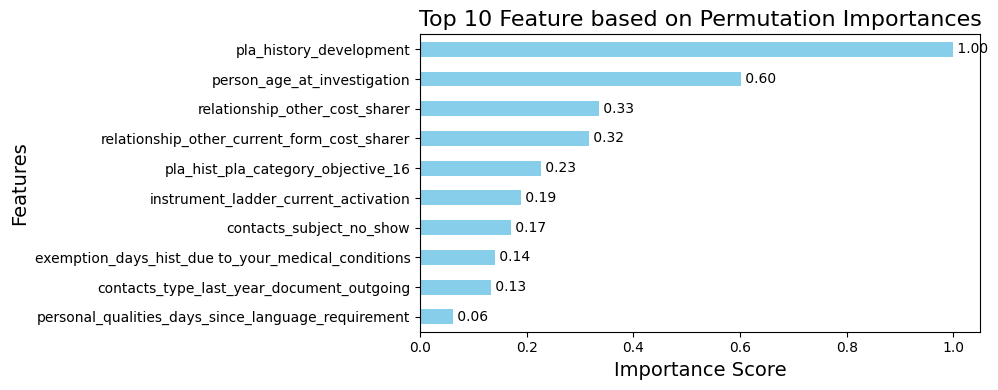

In [427]:
#ANALYZE: no features removed
analyze_features(df, False, 'src/team_2/feature_importance/fi_v0.pkl')

{'18-23': 22400, '23-28': 20600, '28-33': 17500, '33-38': 12900, '38-42': 10800, '42-47': 3000, '52-57': 800, '57-62': 4600, '62-67': 11700}


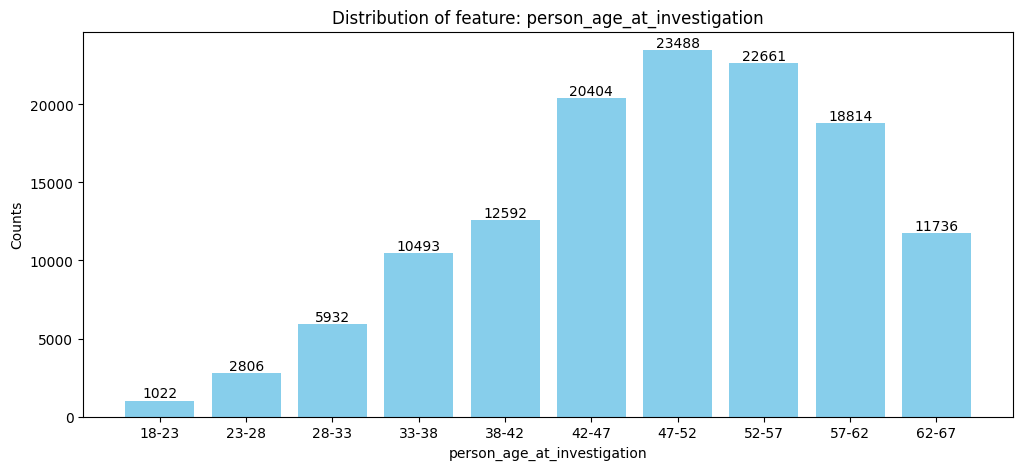

In [428]:
plot_distribution(df['person_age_at_investigation'], 'person_age_at_investigation')

In [429]:
###TEST: bias on age
only = pd.read_csv('data/Experiment_persoon_leeftijd_bij_onderzoek/20_only.csv')
only.head(10)



process_bias(
    data_path='data/Experiment_persoon_leeftijd_bij_onderzoek/20_only.csv',
    model_path='model/gboost2_v1.onnx',
    feature=['persoon_leeftijd_bij_onderzoek'],
    new_value=[50],
    is_range=False,
    detailed_results=True,
    name_original='20 year old',
    name_changed='50 year old'
)


Accuracy for sample of 500 20 year old: 79.0%
Accuracy for sample of 500 50 year old: 83.2%
Percentage checked amongst 20 year old: 64.8%
Percentage checked changed to 50 year old: 33.8%
1.0149048808416996e-23
Model showcases significant bias towards feature - ['persoon_leeftijd_bij_onderzoek']


In [430]:
###FEATURE SELECTION
biased_features.append('persoon_leeftijd_bij_onderzoek')

In [431]:
df = df.drop(name_mapping['persoon_leeftijd_bij_onderzoek'], axis=1)

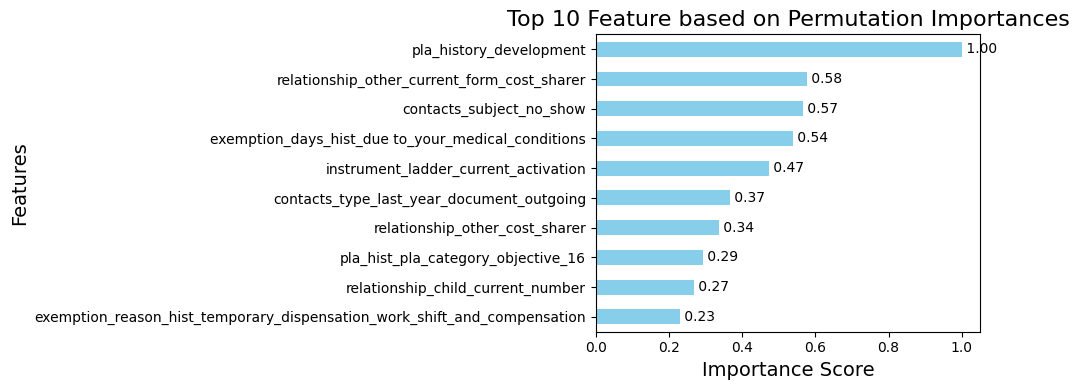

In [432]:
### Get feature importance for dataframe without persoon_leeftijd_bij_onderzoek

###REPEAT STEPS
analyze_features(df, False, 'src/team_2/feature_importance/fi_v1.pkl')

{0: 31000}


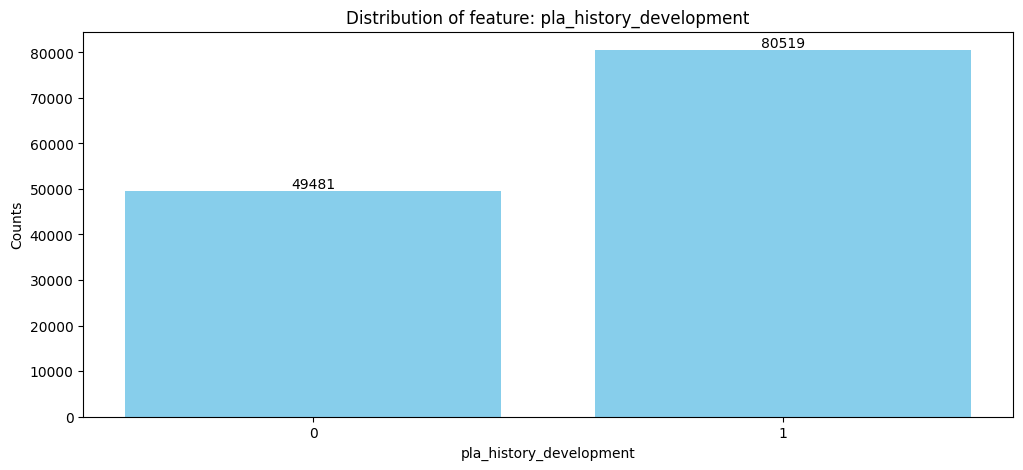

In [433]:
plot_distribution(df['pla_history_development'], 'pla_history_development')

In [434]:
###TEST: bias on history of plans
process_bias(
    data_path='data/Experiment_pla_historie_ontwikkeling/0_only.csv',
    model_path='model/gboost2_v1.onnx',
    feature=['pla_historie_ontwikkeling'],
    new_value=[1],
    is_range=False,
    detailed_results=True,
    name_original='Had no action plan (0)',
    name_changed='Had action plan (1)'
)

Accuracy for sample of 500 Had no action plan (0): 91.2%
Accuracy for sample of 500 Had action plan (1): 83.8%
Percentage checked amongst Had no action plan (0): 42.2%
Percentage checked changed to Had action plan (1): 27.6%
1.1403380354070458e-06
Model showcases significant bias towards feature - ['pla_historie_ontwikkeling']


In [435]:
###FEATURE SELECTION
biased_features.append('pla_historie_ontwikkeling')

In [436]:
df = df.drop(name_mapping['pla_historie_ontwikkeling'], axis=1)

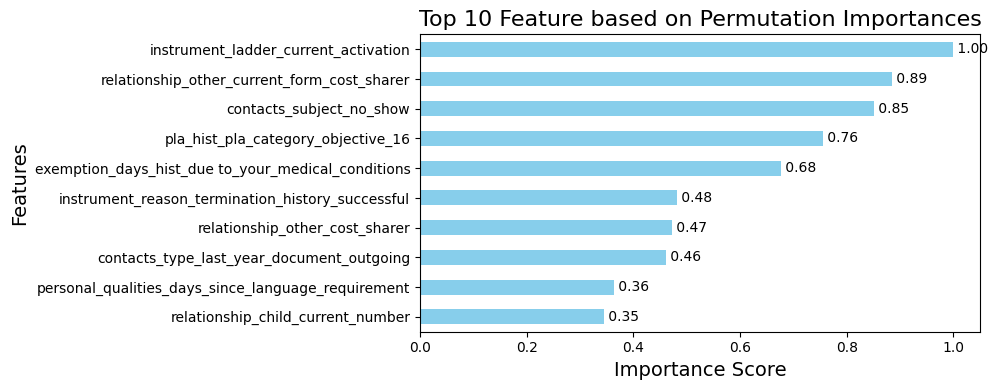

In [437]:
###REPEAT
analyze_features(df, False, 'src/team_2/feature_importance/fi_v2.pkl')

{1: 1000, 2: 54700, 3: 61700}


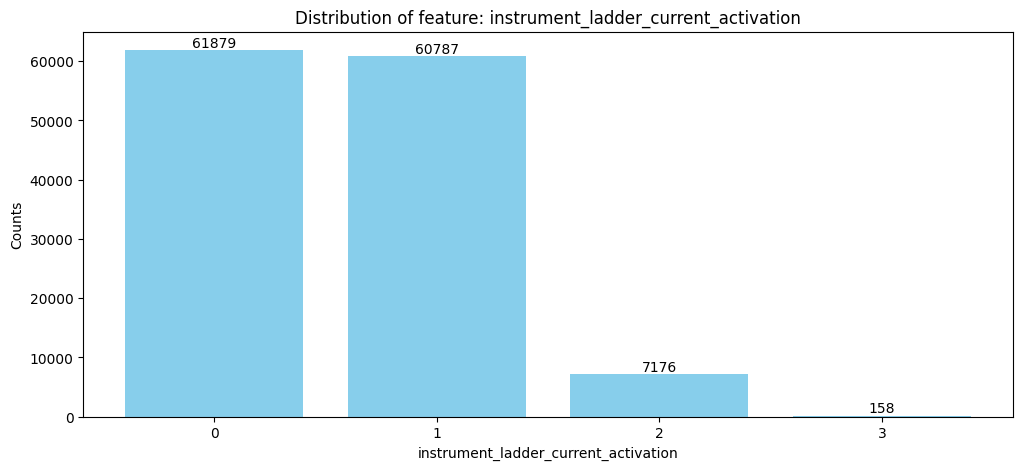

In [438]:
plot_distribution(df['instrument_ladder_current_activation'], 'instrument_ladder_current_activation')

In [439]:
###TEST
process_bias(
    data_path='data/Experiment_instrument_ladder_huidig_activering/01_curr_inst_2-3_labeled.csv',
    model_path='model/gboost2_v1.onnx',
    feature='instrument_ladder_huidig_activering',
    new_value=(0,1),
    is_range=True,
    detailed_results=True,
    name_original='Curr number of instruments: 2-3',
    name_changed='Curr number of instruments: 0-1'
)

Accuracy for sample of 500 Curr number of instruments: 2-3: 96.8%
Accuracy for sample of 500 Curr number of instruments: 0-1: 96.4%
Percentage checked amongst Curr number of instruments: 2-3: 4.4%
Percentage checked changed to Curr number of instruments: 0-1: 5.6%
0.3844930793195265
Model does not showcase significant bias towards feature - instrument_ladder_huidig_activering


In [440]:
biased_features.append('instrument_ladder_huidig_activering')
biased_features

['persoon_leeftijd_bij_onderzoek',
 'pla_historie_ontwikkeling',
 'instrument_ladder_huidig_activering']

In [441]:
df = df.drop(name_mapping['instrument_ladder_huidig_activering'], axis=1)

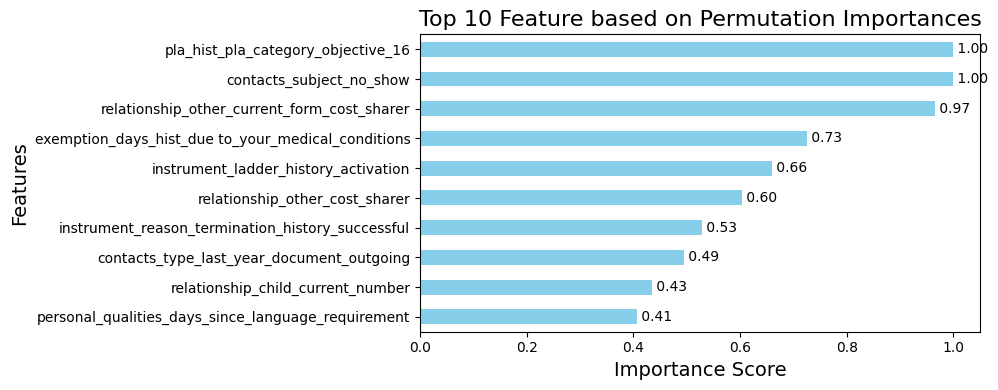

In [442]:
###REPEAT
analyze_features(df, False, 'src/team_2/feature_importance/fi_v3.pkl')

{0: 23900, 2: 30200, 3: 50500, 4: 57000, 5: 58200, 6: 58300}


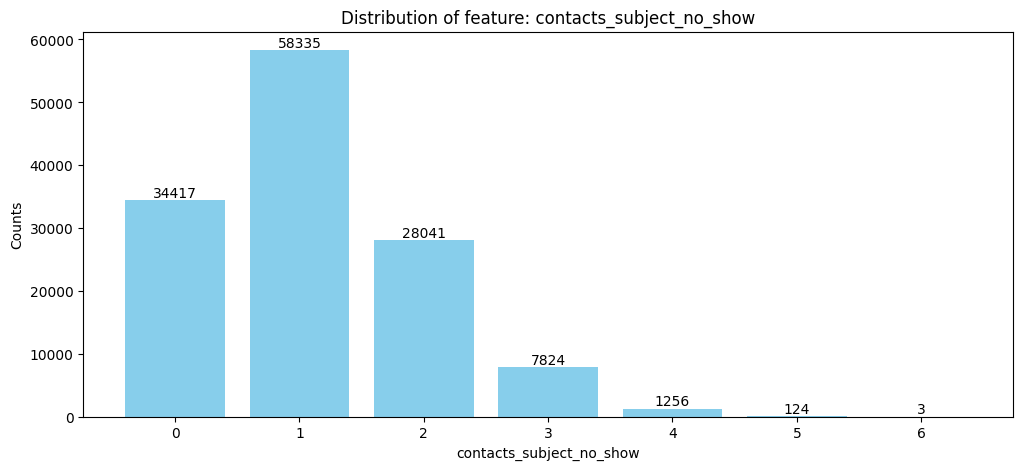

In [443]:
plot_distribution(df['contacts_subject_no_show'], 'contacts_subject_no_show')

In [444]:
process_bias(
    data_path='data/Experiment_contacten_onderwerp_no_show/02_contact_3-6_labeled.csv',
    model_path='model/gboost2_v1.onnx',
    feature='contacten_onderwerp_no_show',
    new_value=(0,2),
    is_range=True,
    detailed_results=True,
    name_original='No show count: 3-6',
    name_changed='No show count: 0-2'
)

Accuracy for sample of 1500 No show count: 3-6: 86.1%
Accuracy for sample of 1500 No show count: 0-2: 85.1%
Percentage checked amongst No show count: 3-6: 33.2%
Percentage checked changed to No show count: 0-2: 20.5%
3.753284730525703e-15
Model showcases significant bias towards feature - contacten_onderwerp_no_show


In [445]:
biased_features.append('contacten_onderwerp_no_show')

In [446]:
df = df.drop(name_mapping['contacten_onderwerp_no_show'], axis=1)

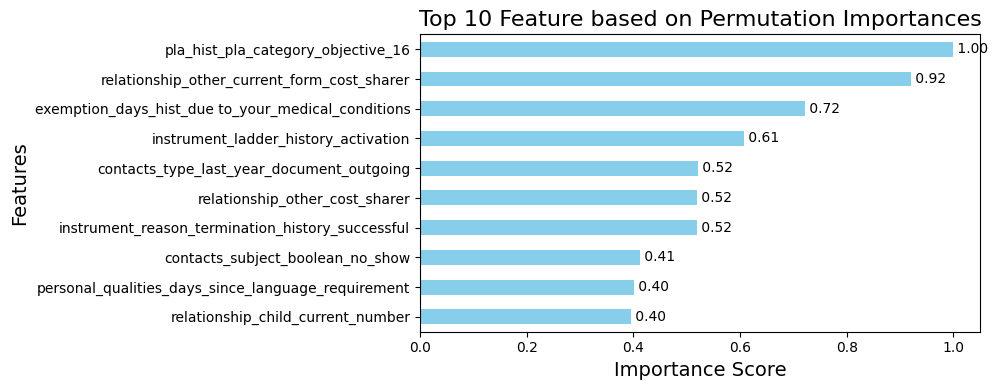

In [447]:
analyze_features(df, False, 'src/team_2/feature_importance/fi_v4.pkl')

{0: 5700, 2: 57500, 3: 64200}


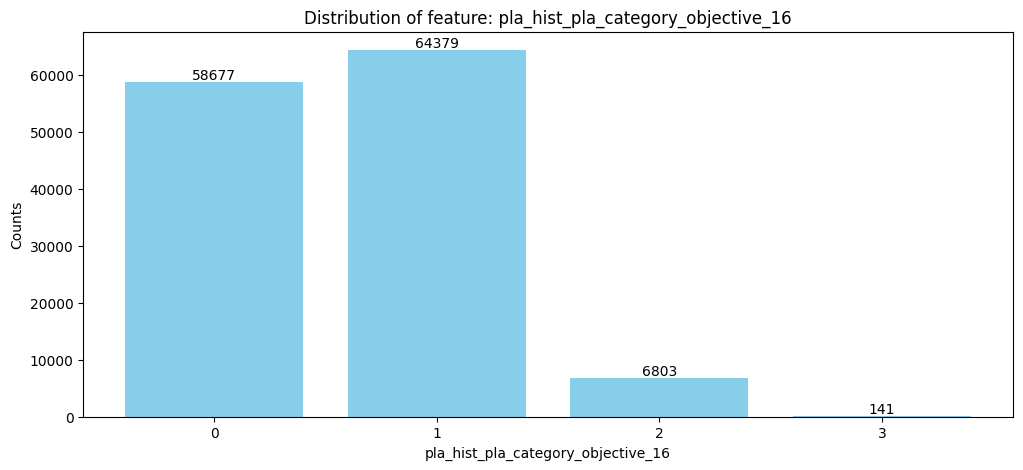

In [448]:
plot_distribution(df['pla_hist_pla_category_objective_16'], 'pla_hist_pla_category_objective_16')

In [449]:
process_bias(
    data_path='data/Experiment_pla_hist_pla_categorie_doelstelling_16/03_obj_16_2-3_labeled.csv',
    model_path='model/gboost2_v0.onnx',
    feature='pla_hist_pla_categorie_doelstelling_16',
    new_value=(0,1),
    is_range=True,
    detailed_results=True,
    name_original='Obj 16 count: 2-3',
    name_changed='Obj 16 count: 0-1'
)

Accuracy for sample of 1000 Obj 16 count: 2-3: 98.5%
Accuracy for sample of 1000 Obj 16 count: 0-1: 98.2%
Percentage checked amongst Obj 16 count: 2-3: 1.6%
Percentage checked changed to Obj 16 count: 0-1: 2.1%
0.40695832131472565
Model does not showcase significant bias towards feature - pla_hist_pla_categorie_doelstelling_16


In [450]:
biased_features.append('')
biased_features

['persoon_leeftijd_bij_onderzoek',
 'pla_historie_ontwikkeling',
 'instrument_ladder_huidig_activering',
 'contacten_onderwerp_no_show',
 '']

In [451]:
# Check if there is a bias towards females
process_bias(
    data_path='data/Experiment_persoon_geslacht_vrouw/male_only.csv',
    model_path='model/gboost2_v1.onnx',
    feature=[['persoon_geslacht_vrouw']],
    new_value=[1],
    is_range=False,
    detailed_results=True,
    name_original='Male is true',
    name_changed='Female is true'
)

Accuracy for sample of 1000 Male is true: 65.1%
Accuracy for sample of 1000 Female is true: 52.5%
Percentage checked amongst Male is true: 45.2%
Percentage checked changed to Female is true: 58.2%
5.272894010451662e-09
Model showcases significant bias towards feature - [['persoon_geslacht_vrouw']]


### Data Manipulation

In [452]:
# load in feature selected df
df_feature_selected = pd.read_csv('data/biased_feature_selected.csv')

WE WANT TO INTRODUCE MORE BIAS TOWARDS WOMAN

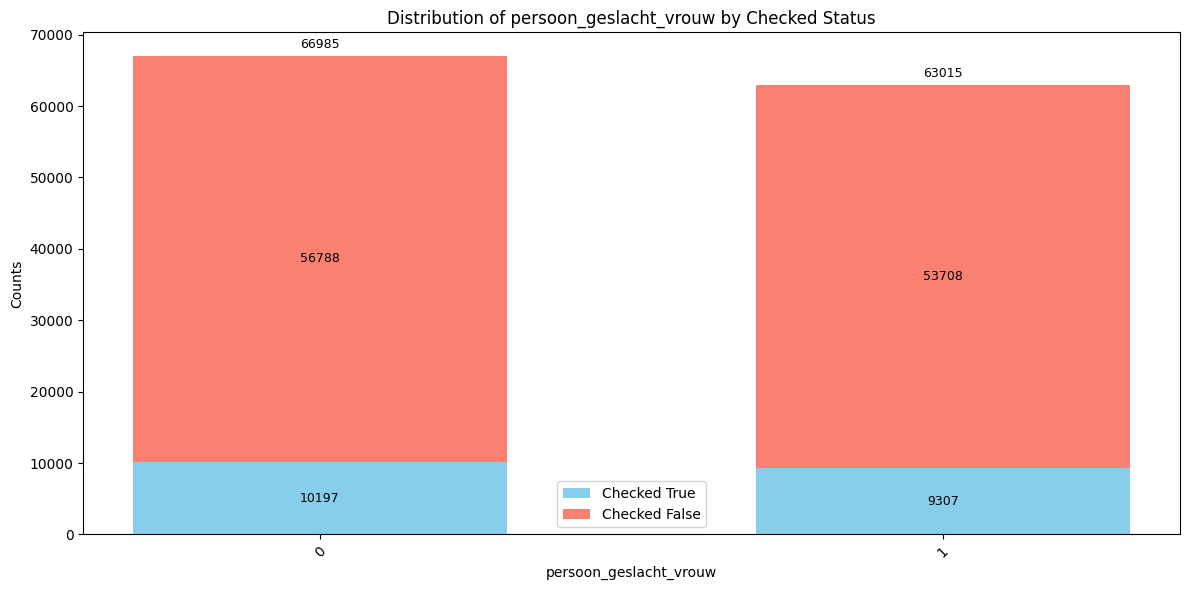

In [453]:

# Check distribution on women in data
plot_dist_checked(df=df_feature_selected, feature='persoon_geslacht_vrouw')

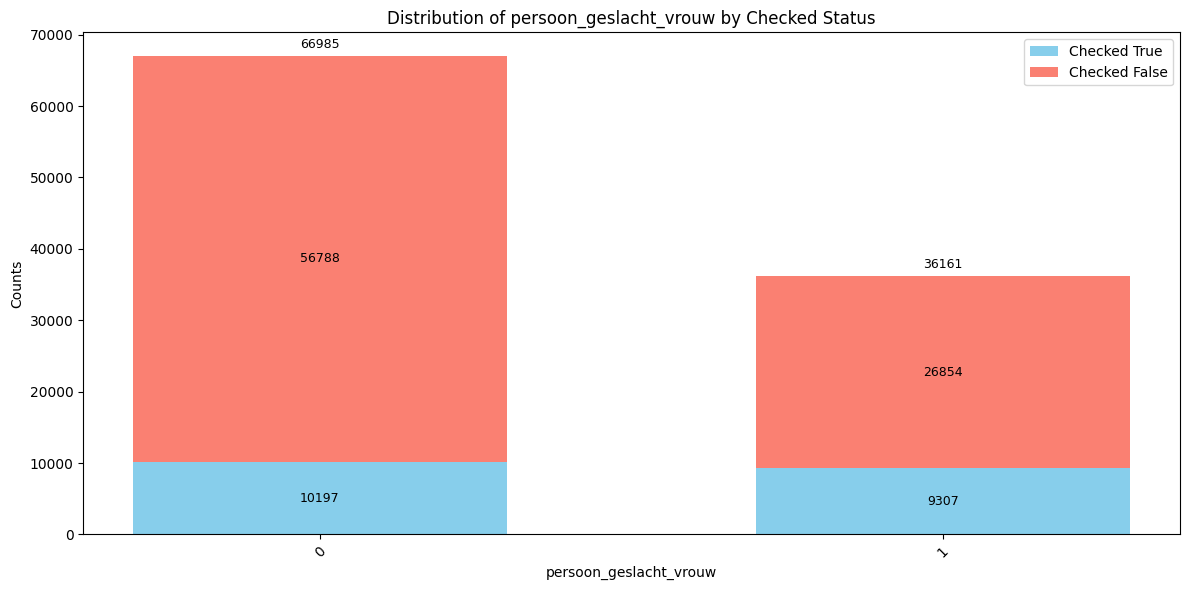

In [454]:
# Introduce more bias towards women
manipulated_data = data_manipulator(
    data=df_feature_selected,
    feature=['persoon_geslacht_vrouw'],
    manipulation='remove',
    fraction=0.5,
    remove_condition=lambda row: row['persoon_geslacht_vrouw'] == 1 and row['checked'] == False
)

### We removed 80% of the labels where the women has a checked label that is false from training data

plot_dist_checked(df=manipulated_data, feature='persoon_geslacht_vrouw')

Now manipulate towards younger age groups

c:\Users\alexz\OneDrive - Delft University of Technology\SE and Testing AI Systems\TestingProject\src\utils\plot_utils.py:147: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby(['Bins', 'checked']).size().unstack(fill_value=0)


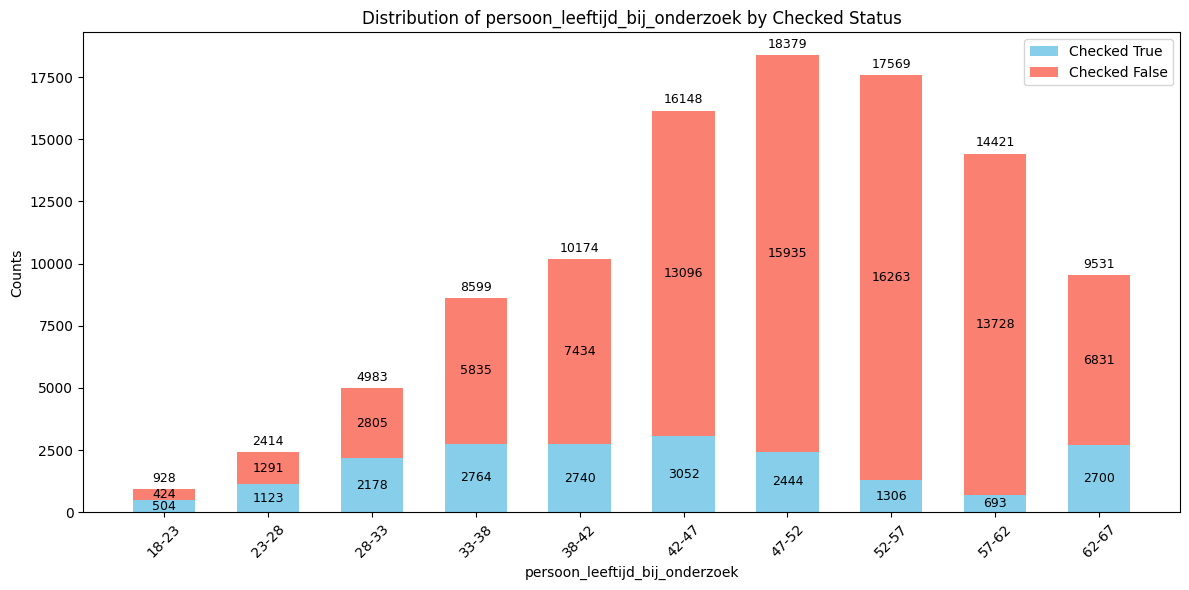

In [455]:
# Manipulate age
# Check distribution on age in data
plot_dist_checked(df=manipulated_data, feature='persoon_leeftijd_bij_onderzoek')

c:\Users\alexz\OneDrive - Delft University of Technology\SE and Testing AI Systems\TestingProject\src\utils\plot_utils.py:147: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby(['Bins', 'checked']).size().unstack(fill_value=0)


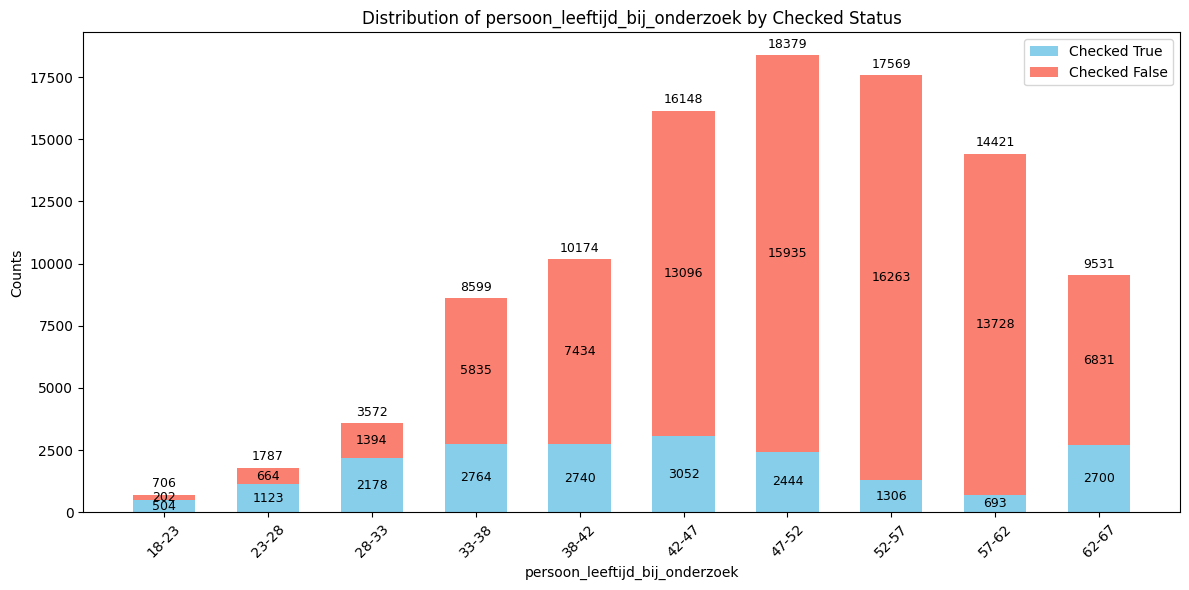

In [456]:
# Make the bias towards young age worse

### Remove 50% of the labels where age is between 18 and 33 and checked label is false, introducing more bias towards young age group
manipulated_data = data_manipulator(
    data=manipulated_data,
    feature=['persoon_leeftijd_bij_onderzoek'],
    manipulation='remove',
    fraction=0.5,
    remove_condition = lambda row: (18 <= row['persoon_leeftijd_bij_onderzoek'] <= 33) and (row['checked'] == False)
)

plot_dist_checked(df=manipulated_data, feature='persoon_leeftijd_bij_onderzoek')

Now manipulate towards people with a history for development

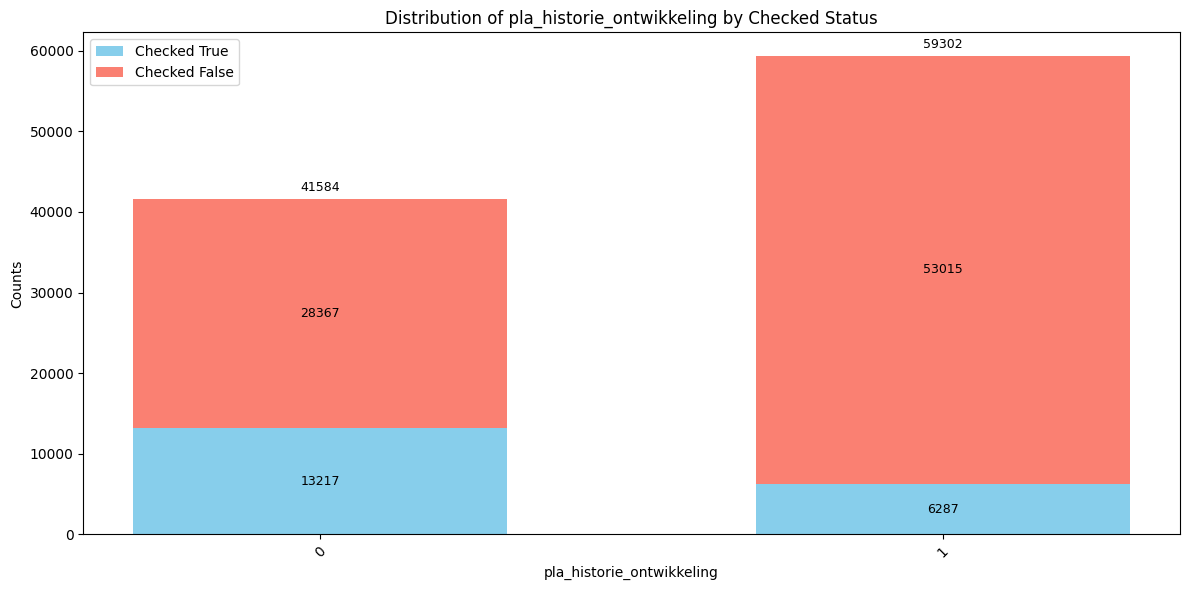

In [457]:
# Check pla_historie_ontwikkeling distribution
plot_dist_checked(df=manipulated_data, feature='pla_historie_ontwikkeling')

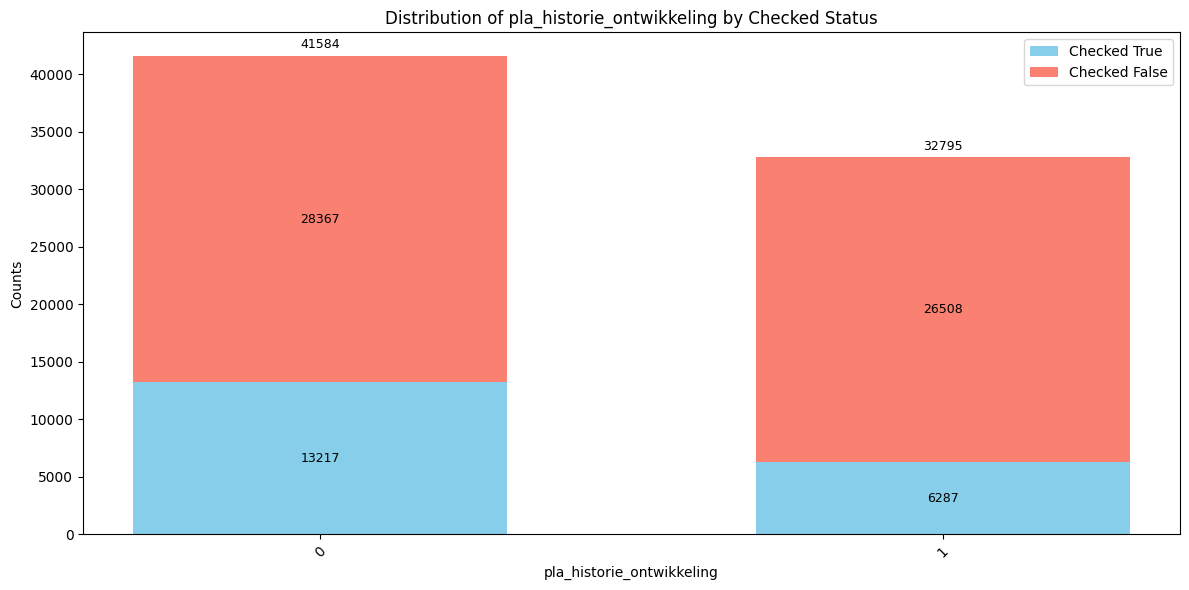

In [458]:
# Make the bias towards people with PLA history worse

### Remove 50% of the labels where pla historie is false and checked
manipulated_data = data_manipulator(
    data=manipulated_data,
    feature=['pla_historie_ontwikkeling'],
    manipulation='remove',
    fraction=0.5,
    remove_condition = lambda row: (row['pla_historie_ontwikkeling'] == 1) and (row['checked'] == False)
)

plot_dist_checked(df=manipulated_data, feature='pla_historie_ontwikkeling')

Now let's export the manipulated dataset to a new file

In [459]:
# Export to new training file
manipulated_data.to_csv('data/manipulated_training_data.csv', index=False)
manipulated_data.describe()

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee
count,74379.000000,74379.000000,74379.000000,74379.000000,74379.000000,74379.000000,74379.000000,74379.000000,74379.000000,74379.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74379.000000,74379.000000
mean,2.933341,2.126649,0.426895,0.508463,9680.251980,0.951330,0.003966,0.003549,0.490837,0.001102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.628509,0.371491
std,1.492465,0.935330,0.526289,0.564692,6282.314027,0.215178,0.062853,0.059471,0.499919,0.033185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088568,0.088568
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232851,0.159063
25%,2.000000,1.000000,0.000000,0.000000,4396.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.574569,0.300823
50%,3.000000,2.000000,0.000000,0.000000,8842.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.639152,0.360848
75%,4.000000,3.000000,1.000000,1.000000,14295.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.699177,0.425431
max,11.000000,7.000000,3.000000,3.000000,24331.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.840937,0.767149


### Train model on biased manipulated dataset

In [460]:
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn

In [461]:
# Let's train a model on the biased women data
df_manipulated = pd.read_csv('data/women_bias_data.csv')

X = df_manipulated.drop(['checked', 'Ja', 'Nee'], axis=1)
y = df_manipulated['checked']

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Select data based on variance (not the final version yet, for now just for testing)
selector = VarianceThreshold()

# Select data based on variance (not the final version yet, for now just for testing)
biased_selector = VarianceThreshold()

# Define a gradient boosting classifier
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

pipeline = Pipeline(steps=[('feature selection', selector), ('classification', classifier)])

# Let's train a simple model
pipeline.fit(X_train, y_train)

# Let's evaluate the model
y_pred = pipeline.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the original model: ', original_accuracy)

c:\Users\alexz\anaconda3\envs\SE_AI\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:112: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
c:\Users\alexz\anaconda3\envs\SE_AI\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:120: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Accuracy of the original model:  0.9384498175548338


In [462]:
# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    pipeline, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

# Let's save the model
onnx.save(onnx_model, "model/gboost2_v2.onnx")

Accuracy of the ONNX model:  0.9384498175548338
